In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit

In [2]:
def Datos(path):
    data = [[],[],[]]
    with open(path) as fobj:
        for i, line in enumerate(fobj):
           # data.append([])
            if line.rsplit() != []:
                row = line.rsplit()   
                for j in range(len(row)):
                    data[j].append(float(row[j]))     
    return np.array(data)

def EffectiveMass(Corr,Nt):
    #We need the root of this function
    def f(x,Corr,t):
        #return Corr[t]/Corr[(t+1)%Nt] - np.cosh(x * (t-Nt/2))/ np.cosh(x * ( (t+1)%Nt - Nt/2 ))
        return Corr[t]/Corr[(t+1)%Nt] - np.cosh(x * (t-Nt/2))/ np.cosh(x * ( (t+1) - Nt/2 ))
    meff = []
    for t in range(Nt):
        sol = optimize.root_scalar(f, args=(Corr,t), method='secant', x0=0.5, x1=1, xtol=1e-15, rtol=1e-15, maxiter=1000)
        if sol.converged == True:
            meff.append(sol.root)
        else:
            print("Solution not found for t={0}".format(t))
            meff.append(np.nan)
    return np.array(meff)

def func(x, a, b):
    return a*np.exp((Nt/2-x)*b)

def format_number(number):
    # Format the number with 2 decimal places
    s = f"{number:.2f}"
    # Remove the decimal point
    s = s.replace('.', '')
    return s

def kappa2mass(kappa):
    return 1/(2*kappa)-2

def mass2kappa(m0):
    return 1/(2*(m0+2))

In [3]:
kappa2mass(0.265)

-0.11320754716981152

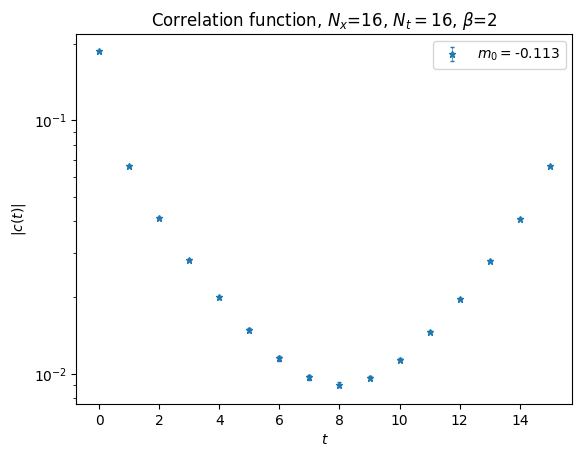

In [11]:
beta, Nx, Nt = 2, 16, 16
masses = [kappa2mass(0.265)]

plt.title(r'Correlation function, $N_x$={0}, $N_t={1}$, $\beta$={2}'.format(Nx,Nt,beta))
plt.ylabel(r'$|c(t)|$')
plt.xlabel(r"$t$")

for m0 in masses:
    path = 'confs/b{0}_{1}x{2}/2D_U1_Ns{1}_Nt{2}_b{0}_m{3}_corr.txt'.format(beta,Nx,Nt,format_number(m0))
    t, Corr, dCorr = Datos(path)
    Corr = abs(Corr)
    plt.errorbar(t,Corr,yerr=dCorr,\
        fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='$m_0=${0}'.format(np.round(m0,3)), capsize=1.5)
plt.yscale('log')
plt.legend()
plt.show()

In [12]:
for t in range(Nt):
    print('C({0})= {1} +- {2}'.format(t,Corr[t],dCorr[t]))

C(0)= 0.1873996 +- 0.0007996933
C(1)= 0.0661174 +- 0.0004042514
C(2)= 0.04109613 +- 0.0003251215
C(3)= 0.02805102 +- 0.000330093
C(4)= 0.01997876 +- 0.0002633303
C(5)= 0.01482191 +- 0.0002473606
C(6)= 0.01149723 +- 0.0002469429
C(7)= 0.009681024 +- 0.0002115704
C(8)= 0.009043656 +- 0.000190051
C(9)= 0.009578583 +- 0.000171798
C(10)= 0.0113507 +- 0.0001902479
C(11)= 0.01459142 +- 0.0001960826
C(12)= 0.0197245 +- 0.0001916156
C(13)= 0.02789829 +- 0.0002343497
C(14)= 0.04097608 +- 0.000285548
C(15)= 0.06589219 +- 0.0003297562


mpi = 0.3558752030823747 +- 0.00848110250366966


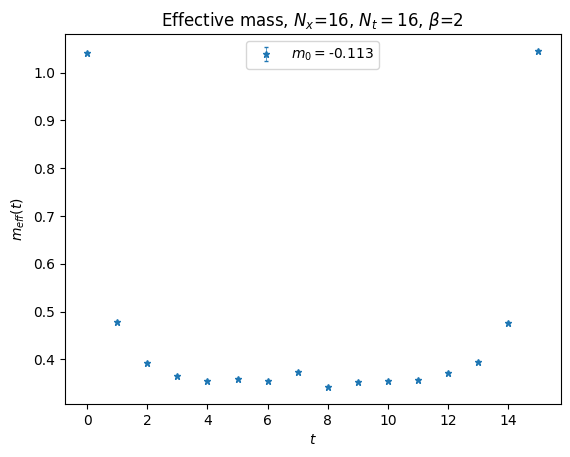

In [14]:
plt.title(r'Effective mass, $N_x$={0}, $N_t={1}$, $\beta$={2}'.format(Nx,Nt,beta))
plt.ylabel(r'$m_{eff}(t)$')
plt.xlabel(r"$t$")

for m0 in masses:
    path = 'confs/b{0}_{1}x{2}/2D_U1_Ns{1}_Nt{2}_b{0}_m{3}_corr.txt'.format(beta,Nx,Nt,format_number(m0))
    t, Corr, dCorr = Datos(path)
    Corr = abs(Corr)
    meff = EffectiveMass(Corr,Nt)
    plt.errorbar(t,meff,yerr=meff*0,\
        fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='$m_0=${0}'.format(np.round(m0,3)), capsize=1.5)
    print("mpi = {0} +- {1}".format(np.mean(meff[4:11]),np.std(meff[4:11])))
#plt.yscale('log')
plt.legend()
plt.show()


In [7]:
#popt, pcov = curve_fit(func, np.arange(Nt)[4:8], Corr[4:8],p0=[0.1,0.1])
#print(popt)
#plt.plot(np.arange(Nt), func(np.arange(Nt), *popt), 'r-',
#         label='fit: a=%5.3f, b=%5.3f'% tuple(popt))
#plt.scatter(np.arange(Nt),Corr)
#plt.yscale('log')

In [8]:
from scipy.sparse import csc_array
from scipy.sparse.linalg import bicgstab

In [9]:
def DatosMat(path):
    data = [[],[],[],[]]
    with open(path) as fobj:
        for i, line in enumerate(fobj):
           # data.append([])
            if line.rsplit() != []:
                row = line.rsplit()   
                for j in range(len(row)):
                    data[j].append(float(row[j]))     
    return data

In [10]:
Nx, Nt = 16, 16
num_configs = 1
dim = Nx*Nt*2
print(dim)
D = np.zeros((dim,dim),dtype=complex)
Dinv = np.zeros((dim,2),dtype=complex)
CorrMat = np.zeros((Nt,num_configs))
Corr = np.zeros(Nt)
dCorr = np.zeros(Nt)
for nconf in range(num_configs):
    row, col, re, im = DatosMat("confs/D{0}.dat".format(nconf))
    for i in range(dim*dim):
        D[ int(row[i]), int(col[i]) ] = re[i] + 1j*im[i] 
    print("Conf {0}".format(nconf))
    for i in range(2):
        can_vec = np.eye(1,dim,i).reshape(dim)
        Dinvcol, exit_code = bicgstab(csc_array(D), can_vec, x0=can_vec,maxiter=1000, rtol=1e-10)
        if exit_code != 0:
            print("convergence failed")
        Dinv[:,i] = Dinvcol
    for t in range(Nt):
        for alf in range(2):
            for x in range(Nx):
                for bet in range(2):
                    indx = 2*(x*Nt + t)+alf 
                    #the indx for bet is just bet
                    CorrMat[t,nconf] += np.real(Dinv[indx,bet] * np.conjugate(Dinv[indx,bet]))
        CorrMat[t,nconf] /= np.sqrt(Nx)

512


FileNotFoundError: [Errno 2] No such file or directory: 'confs/D0.dat'

In [ ]:
nconf = 0
row, col, re, im = DatosMat("confs/D{0}.dat".format(nconf))
for i in range(dim*dim):
    D[ int(row[i]), int(col[i]) ] = re[i] + 1j*im[i] 
Eigs = np.linalg.eig(D)[0]
x = [ele.real for ele in Eigs] 
# extract imaginary part 
y = [ele.imag for ele in Eigs]
norms = [np.abs(ele) for ele in Eigs]

In [ ]:
print(max(norms)/min(norms))
for i in range(len(x)):
    if np.abs(y[i]) < 1e-10:
        print(x[i],y[i])

In [ ]:
plt.scatter(x,y)
plt.axvline(x=0, color='r', linestyle='-')

In [ ]:
1-0.19

In [ ]:
2-0.81

In [ ]:
for t in range(Nt):
    Corr[t] = np.mean(CorrMat[t])
    dCorr[t] = np.std(CorrMat[t])/np.sqrt(num_configs)

In [ ]:
beta, Nx, Nt = 2, 16, 16
m0 = -0.16

plt.title(r'Correlation function, $N_x$={0}, $N_t={1}$, $\beta$={2}'.format(Nx,Nt,beta))
plt.ylabel(r'$|c(t)|$')
plt.xlabel(r"$t$")

plt.errorbar(np.arange(Nt),Corr,yerr=dCorr,\
    fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='$m_0=${0} python'.format(m0), capsize=1.5)

path = 'confs/b{0}_{1}x{2}/2D_U1_Ns{1}_Nt{2}_b{0}_m{3}_corr.txt'.format(beta,Nx,Nt,str(m0).replace(".",""))
t, data, ddata = Datos(path)
data = abs(data)
plt.errorbar(t,data,yerr=ddata,\
    fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='$m_0=${0}'.format(m0), capsize=1.5)
plt.yscale('log')
plt.legend()
plt.show()
for i in np.arange(Nt):
    print(Corr[i],data[i])

In [ ]:
plt.title(r'Effective mass, $N_x$={0}, $N_t={1}$, $\beta$={2}'.format(Nx,Nt,beta))
plt.ylabel(r'$m_{eff}(t)$')
plt.xlabel(r"$t$")
meff = EffectiveMass(Corr,Nt)
plt.errorbar(t,meff,yerr=meff*0,\
    fmt='*',markersize='5',elinewidth=0.5,solid_capstyle='projecting',label='$m_0=${0}'.format(m0), capsize=1.5)
#plt.yscale('log')
plt.legend()
plt.show()
print(np.mean(meff[2:12]))

In [ ]:
def func(x, a, b):
    return a*np.exp((Nt/2-x)*b)

popt, pcov = curve_fit(func, np.arange(Nt)[4:8], Corr[4:8],p0=[0.1,0.1])
print(popt)
plt.plot(np.arange(Nt), func(np.arange(Nt), *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f'% tuple(popt))
plt.scatter(np.arange(Nt),Corr)
plt.yscale('log')